In [1]:
import numpy as np
import pandas as pd
import itertools 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,  precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import RFE

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
#supress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
train = pd.read_csv('train.csv')  
train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home      482087.00                  NaN       0.00   
1       Own Home     1025487.00            10+ years       0.00   
2  Home Mortgage      751412.00              8 years       0.00   
3       Own Home      805068.00              6 years       0.00   
4           Rent      776264.00              8 years       0.00   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                    11.00                    26.30            685960.00   
1                    15.00                    15.30           1181730.00   
2                    11.00                    35.00           1182434.00   
3                     8.00                    22.50            147400.00   
4                    13.00                    13.60            385836.00   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                       1.00                           nan          1.00   
1                       0.00                           nan          0.00   
2                       0.00                           nan          0.00   
3                       1.00                           nan          1.00   
4                       1.00                           nan          0.00   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term          99999999.00   
1  debt consolidation   Long Term            264968.00   
2  debt consolidation  Short Term          99999999.00   
3  debt consolidation  Short Term            121396.00   
4  debt consolidation  Short Term            125840.00   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                47386.00       7914.00        749.00               0  
1               394972.00      18373.00        737.00               1  
2               308389.00      13651.00        742.00               0  
3                95855.00      11338.00        694.00               0  
4                93309.00       7180.00        719.00               0

In [7]:
test = pd.read_csv('test.csv')  
test.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            nan              4 years       0.00   
1           Rent      231838.00               1 year       0.00   
2  Home Mortgage     1152540.00              3 years       0.00   
3  Home Mortgage     1220313.00            10+ years       0.00   
4  Home Mortgage     2340952.00              6 years       0.00   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     9.00                    12.50            220968.00   
1                     6.00                    32.70             55946.00   
2                    10.00                    13.70            204600.00   
3                    16.00                    17.00            456302.00   
4                    11.00                    23.60           1207272.00   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                       0.00                         70.00          0.00   
1                       0.00                          8.00          0.00   
2                       0.00                           nan          0.00   
3                       0.00                         70.00          0.00   
4                       0.00                           nan          0.00   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term            162470.00   
1  educational expenses  Short Term             78298.00   
2    debt consolidation  Short Term            200178.00   
3    debt consolidation  Short Term            217382.00   
4    debt consolidation   Long Term            777634.00   

   Current Credit Balance  Monthly Debt  Credit Score  
0               105906.00       6813.00           nan  
1                46037.00       2318.00        699.00  
2               146490.00      18729.00       7260.00  
3               213199.00      27559.00        739.00  
4               425391.00      42605.00        706.00

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [9]:
train.describe()

Annual Income  Tax Liens  Number of Open Accounts  \
count        5943.00    7500.00                  7500.00   
mean      1366391.72       0.03                    11.13   
std        845339.20       0.27                     4.91   
min        164597.00       0.00                     2.00   
25%        844341.00       0.00                     8.00   
50%       1168386.00       0.00                    10.00   
75%       1640137.00       0.00                    14.00   
max      10149344.00       7.00                    43.00   

       Years of Credit History  Maximum Open Credit  \
count                  7500.00              7500.00   
mean                     18.32            945153.73   
std                       7.04          16026216.67   
min                       4.00                 0.00   
25%                      13.50            279229.50   
50%                      17.00            478159.00   
75%                      21.80            793501.50   
max                      57.70        1304726170.00   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                    7500.00                       3419.00       7486.00   
mean                        0.17                         34.69          0.12   
std                         0.50                         21.69          0.35   
min                         0.00                          0.00          0.00   
25%                         0.00                         16.00          0.00   
50%                         0.00                         32.00          0.00   
75%                         0.00                         50.00          0.00   
max                         7.00                        118.00          4.00   

       Current Loan Amount  Current Credit Balance  Monthly Debt  \
count              7500.00                 7500.00       7500.00   
mean           11873177.45               289833.24      18314.45   
std            31926122.97               317871.38      11926.76   
min               11242.00                    0.00          0.00   
25%              180169.00               114256.50      10067.50   
50%              309573.00               209323.00      16076.50   
75%              519882.00               360406.25      23818.00   
max            99999999.00              6506797.00     136679.00   

       Credit Score  Credit Default  
count       5943.00         7500.00  
mean        1151.09            0.28  
std         1604.45            0.45  
min          585.00            0.00  
25%          711.00            0.00  
50%          731.00            0.00  
75%          743.00            1.00  
max         7510.00            1.00

In [10]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Fixing outliers**

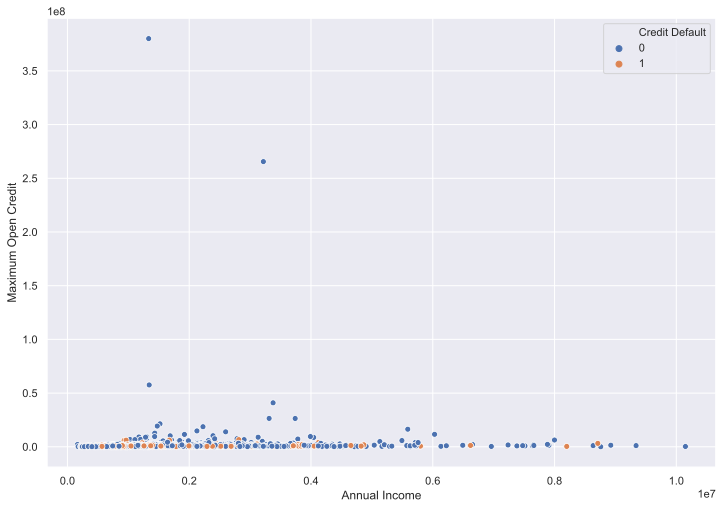

In [11]:
sns.set(rc={'figure.figsize':(12,8.27)})
sns.scatterplot(x='Annual Income', y='Maximum Open Credit',
                hue='Credit Default', data=train)

In [12]:
train[train['Maximum Open Credit'] >25000000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
44    Have Mortgage     1334256.00            10+ years       0.00   
617   Home Mortgage            nan              3 years       0.00   
2023           Rent     1342825.00            10+ years       0.00   
2617  Home Mortgage     3217802.00            10+ years       0.00   
2763  Home Mortgage     3377440.00            10+ years       0.00   
4769  Home Mortgage     3739960.00              9 years       0.00   
7026  Home Mortgage     3312365.00              5 years       0.00   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
44                      17.00                    15.40         380052288.00   
617                     13.00                    27.50        1304726170.00   
2023                    12.00                    16.30          57562560.00   
2617                    12.00                    35.50         265512874.00   
2763                    11.00                    23.20          40923894.00   
4769                     7.00                    22.80          26343328.00   
7026                    13.00                    25.30          26406996.00   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
44                         1.00                         35.00          0.00   
617                        0.00                           nan          0.00   
2023                       0.00                           nan          0.00   
2617                       0.00                           nan          0.00   
2763                       0.00                         59.00          0.00   
4769                       0.00                           nan          0.00   
7026                       0.00                         50.00          0.00   

                 Purpose        Term  Current Loan Amount  \
44           take a trip  Short Term             33110.00   
617   debt consolidation  Short Term            529892.00   
2023               other  Short Term            166826.00   
2617               other  Short Term             50116.00   
2763   home improvements  Short Term          99999999.00   
4769   home improvements  Short Term            757834.00   
7026   home improvements   Long Term          99999999.00   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
44                 656450.00      34357.00        729.00               0  
617               1126814.00       5492.00           nan               0  
2023               944547.00       9176.00        749.00               0  
2617              1834450.00      20272.00        750.00               0  
2763              1908550.00       5770.00        743.00               0  
4769              6506797.00      38023.00        703.00               0  
7026              2440246.00      39196.00        745.00               0

In [13]:
#train.loc[train['Maximum Open Credit'] >25000000,'Maximum Open Credit']=train['Maximum Open Credit'].mean()

#строки с этими выбросам ну очень странные, лучше их совсем удалить
train.drop(train[train['Maximum Open Credit'] >25000000].index, inplace=True)

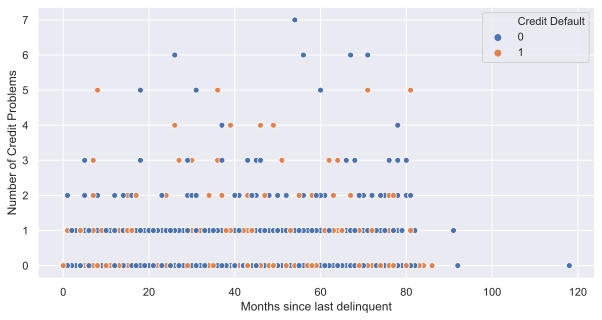

In [14]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(x='Months since last delinquent', y='Number of Credit Problems',
                hue='Credit Default', data=train)

In [15]:
train.loc[train['Months since last delinquent'] >100,'Months since last delinquent']=train.loc[train['Months since last delinquent'] < 100,'Months since last delinquent'].mean()

([<matplotlib.axis.XTick at 0x7f894c5c0ad0>,
 <a list of 5 Text xticklabel objects>)

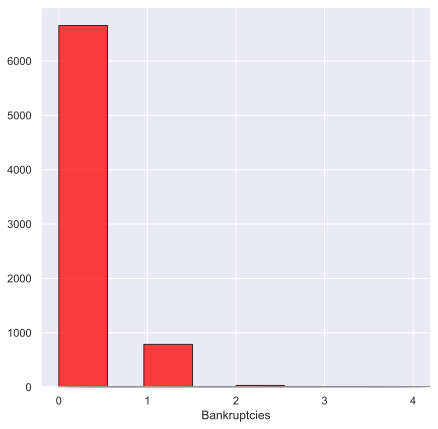

In [16]:
plt.figure(figsize=(7,7))
sns.distplot(train['Bankruptcies'], color = 'red', kde=False, hist_kws={"width":0.55,'edgecolor':'black', 'alpha':0.75})
plt.xticks([0, 1, 2, 3, 4])

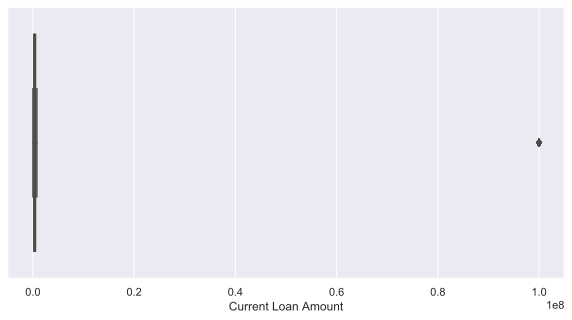

In [17]:
sns.boxplot(train['Current Loan Amount'])

In [18]:
train.loc[train['Current Loan Amount'] > 1000000,'Current Loan Amount'] = train[train['Current Loan Amount'] < 1000000]['Current Loan Amount'].mean()

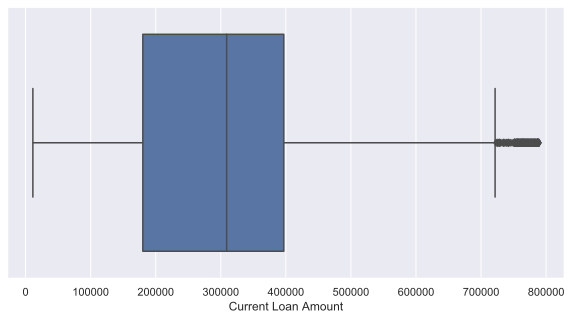

In [19]:
sns.boxplot(train['Current Loan Amount'])

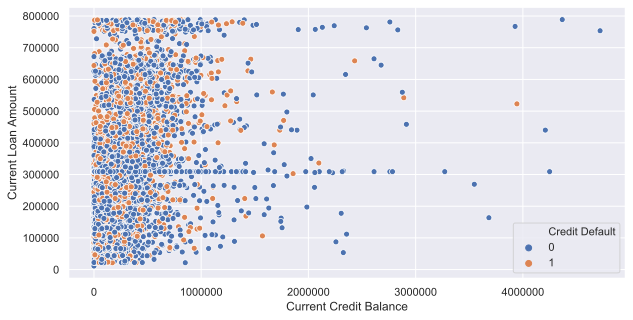

In [20]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(x='Current Credit Balance', y='Current Loan Amount',
                hue='Credit Default', data=train)

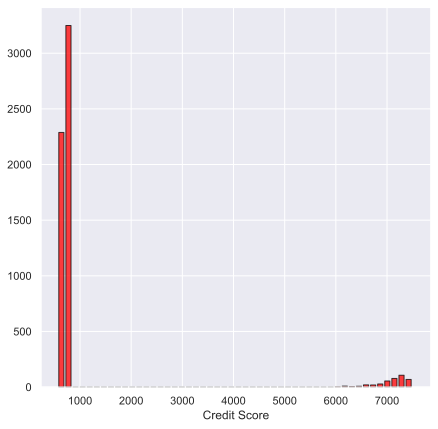

In [21]:
plt.figure(figsize=(7,7))
sns.distplot(train[train['Credit Score'].notna()]['Credit Score'], color = 'red', kde=False, hist_kws={"width":100.55,'edgecolor':'black', 'alpha':0.75})

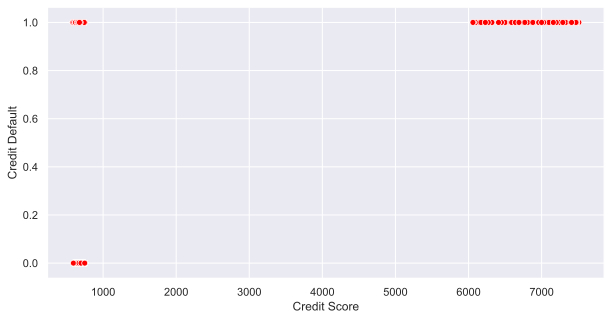

In [22]:
sns.scatterplot(train[train['Credit Score'].notna()]['Credit Score'], train['Credit Default'], color = 'red')

In [23]:
train.loc[train['Credit Score'] > 1000,'Credit Score'] = train[train['Credit Score'] < 1000]['Credit Score'].mean()

**Fill in gaps (n/a values)**

In [24]:
train.describe()

Annual Income  Tax Liens  Number of Open Accounts  \
count        5937.00    7493.00                  7493.00   
mean      1365022.97       0.03                    11.13   
std        844080.99       0.27                     4.91   
min        164597.00       0.00                     2.00   
25%        844113.00       0.00                     8.00   
50%       1168158.00       0.00                    10.00   
75%       1639567.00       0.00                    14.00   
max      10149344.00       7.00                    43.00   

       Years of Credit History  Maximum Open Credit  \
count                  7493.00              7493.00   
mean                     18.31            665571.18   
std                       7.04            879421.26   
min                       4.00                 0.00   
25%                      13.50            278850.00   
50%                      17.00            477488.00   
75%                      21.80            792990.00   
max                      57.70          21372428.00   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                    7493.00                       3416.00       7479.00   
mean                        0.17                         34.66          0.12   
std                         0.50                         21.65          0.35   
min                         0.00                          0.00          0.00   
25%                         0.00                         16.00          0.00   
50%                         0.00                         32.00          0.00   
75%                         0.00                         50.00          0.00   
max                         7.00                         92.00          4.00   

       Current Loan Amount  Current Credit Balance  Monthly Debt  \
count              7493.00                 7493.00       7493.00   
mean             309025.50               288046.36      18311.24   
std              171312.65               307441.75      11923.99   
min               11242.00                    0.00          0.00   
25%              180202.00               114171.00      10071.00   
50%              309025.50               209285.00      16075.00   
75%              396880.00               359081.00      23810.00   
max              789030.00              4720132.00     136679.00   

       Credit Score  Credit Default  
count       5937.00         7493.00  
mean         720.69            0.28  
std           26.71            0.45  
min          585.00            0.00  
25%          711.00            0.00  
50%          727.00            0.00  
75%          740.00            1.00  
max          751.00            1.00

In [25]:
train.loc[train['Annual Income'].isnull(),'Annual Income']=train['Annual Income'].median()
train.loc[train['Bankruptcies'].isnull(),'Bankruptcies']= -1
train.loc[train['Credit Score'].isnull(),'Credit Score']= -1
train.loc[train['Years in current job'].isnull(),'Years in current job'] = "-1"

In [26]:
#drop the "Months since last delinquent" column because there are too many empty values.
train.drop('Months since last delinquent', axis=1, inplace=True)

In [27]:
for obj_colname in train.select_dtypes(include='object').columns:
    print(str(obj_colname) + '\n\n' + str(train[obj_colname].value_counts()) + '\n' + '*' * 50 + '\n')

Home Ownership

Home Mortgage    3632
Rent             3203
Own Home          647
Have Mortgage      11
Name: Home Ownership, dtype: int64
**************************************************

Years in current job

10+ years    2328
2 years       705
3 years       619
< 1 year      563
5 years       515
1 year        504
4 years       469
6 years       426
7 years       396
-1            371
8 years       339
9 years       258
Name: Years in current job, dtype: int64
**************************************************

Purpose

debt consolidation      5943
other                    663
home improvements        409
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               36
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
******

In [28]:
train.groupby('Purpose').agg({'Annual Income': 'mean', 'Credit Default': 'mean'}).reset_index()

Purpose  Annual Income  Credit Default
0          business loan     1505094.43            0.43
1              buy a car     1251160.49            0.25
2              buy house     1619115.18            0.26
3     debt consolidation     1310470.17            0.28
4   educational expenses     1178290.70            0.10
5      home improvements     1516071.51            0.26
6         major purchase     1302395.38            0.23
7          medical bills     1522307.56            0.31
8                 moving     1027086.45            0.18
9                  other     1272415.53            0.30
10      renewable energy     1168158.00            1.00
11        small business     1290062.73            0.54
12           take a trip     1152369.53            0.28
13              vacation     1424346.88            0.25
14               wedding     1909947.13            0.27

In [29]:
train['Years in current job'] = train['Years in current job'].str.extract('(\d+)').astype(int)

In [30]:
train.groupby('Years in current job').agg({'Annual Income': 'mean', 'Credit Default': 'mean'}).reset_index()

Years in current job  Annual Income  Credit Default
0                     1     1157076.94            0.30
1                     2     1292136.02            0.27
2                     3     1348903.31            0.27
3                     4     1328761.23            0.28
4                     5     1289044.04            0.28
5                     6     1286453.34            0.29
6                     7     1303216.81            0.28
7                     8     1352051.32            0.27
8                     9     1360574.61            0.25
9                    10     1439634.10            0.28

In [31]:
train.loc[train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
train.loc[train['Purpose'] == 'renewable energy', 'Purpose'] = 'other'

In [32]:
for obj_colname in train.select_dtypes(include='object').columns:
    train = pd.concat([train, pd.get_dummies(train[obj_colname], prefix=obj_colname)], axis=1)

In [33]:
train = train[train.columns.drop(['Home Ownership', 'Purpose', 'Term'])]

In [34]:
train.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0      482087.00                     1       0.00                    11.00   
1     1025487.00                    10       0.00                    15.00   
2      751412.00                     8       0.00                    11.00   
3      805068.00                     6       0.00                     8.00   
4      776264.00                     8       0.00                    13.00   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                    26.30            685960.00                       1.00   
1                    15.30           1181730.00                       0.00   
2                    35.00           1182434.00                       0.00   
3                    22.50            147400.00                       1.00   
4                    13.60            385836.00                       1.00   

   Bankruptcies  Current Loan Amount  Current Credit Balance  ...  \
0          1.00            309025.50                47386.00  ...   
1          0.00            264968.00               394972.00  ...   
2          0.00            309025.50               308389.00  ...   
3          1.00            121396.00                95855.00  ...   
4          0.00            125840.00                93309.00  ...   

   Purpose_major purchase  Purpose_medical bills  Purpose_moving  \
0                       0                      0               0   
1                       0                      0               0   
2                       0                      0               0   
3                       0                      0               0   
4                       0                      0               0   

   Purpose_other  Purpose_small business  Purpose_take a trip  \
0              0                       0                    0   
1              0                       0                    0   
2              0                       0                    0   
3              0                       0                    0   
4              0                       0                    0   

   Purpose_vacation  Purpose_wedding  Term_Long Term  Term_Short Term  
0                 0                0               0                1  
1                 0                0               1                0  
2                 0                0               0                1  
3                 0                0               0                1  
4                 0                0               0                1  

[5 rows x 32 columns]

**Check features' correlation**

In [35]:
#first of all delete one dummy variable for every str column
train = train[['Annual Income',
               'Tax Liens',
               'Number of Open Accounts',
               'Years of Credit History',
               'Maximum Open Credit',
               'Number of Credit Problems',
               'Bankruptcies',
               'Current Loan Amount',
               'Current Credit Balance',
               'Monthly Debt',
               'Credit Score',
               'Home Ownership_Home Mortgage',
               'Home Ownership_Rent',
               'Years in current job',
               'Purpose_business loan',
               'Purpose_buy a car',
               'Purpose_buy house',
               'Purpose_debt consolidation',
               'Purpose_educational expenses',
               'Purpose_home improvements',
               'Purpose_major purchase',
               'Purpose_medical bills',
               'Purpose_moving',
               'Purpose_small business',
               'Purpose_take a trip',
               'Purpose_vacation',
               'Purpose_wedding',
               'Term_Long Term',
               'Credit Default']]

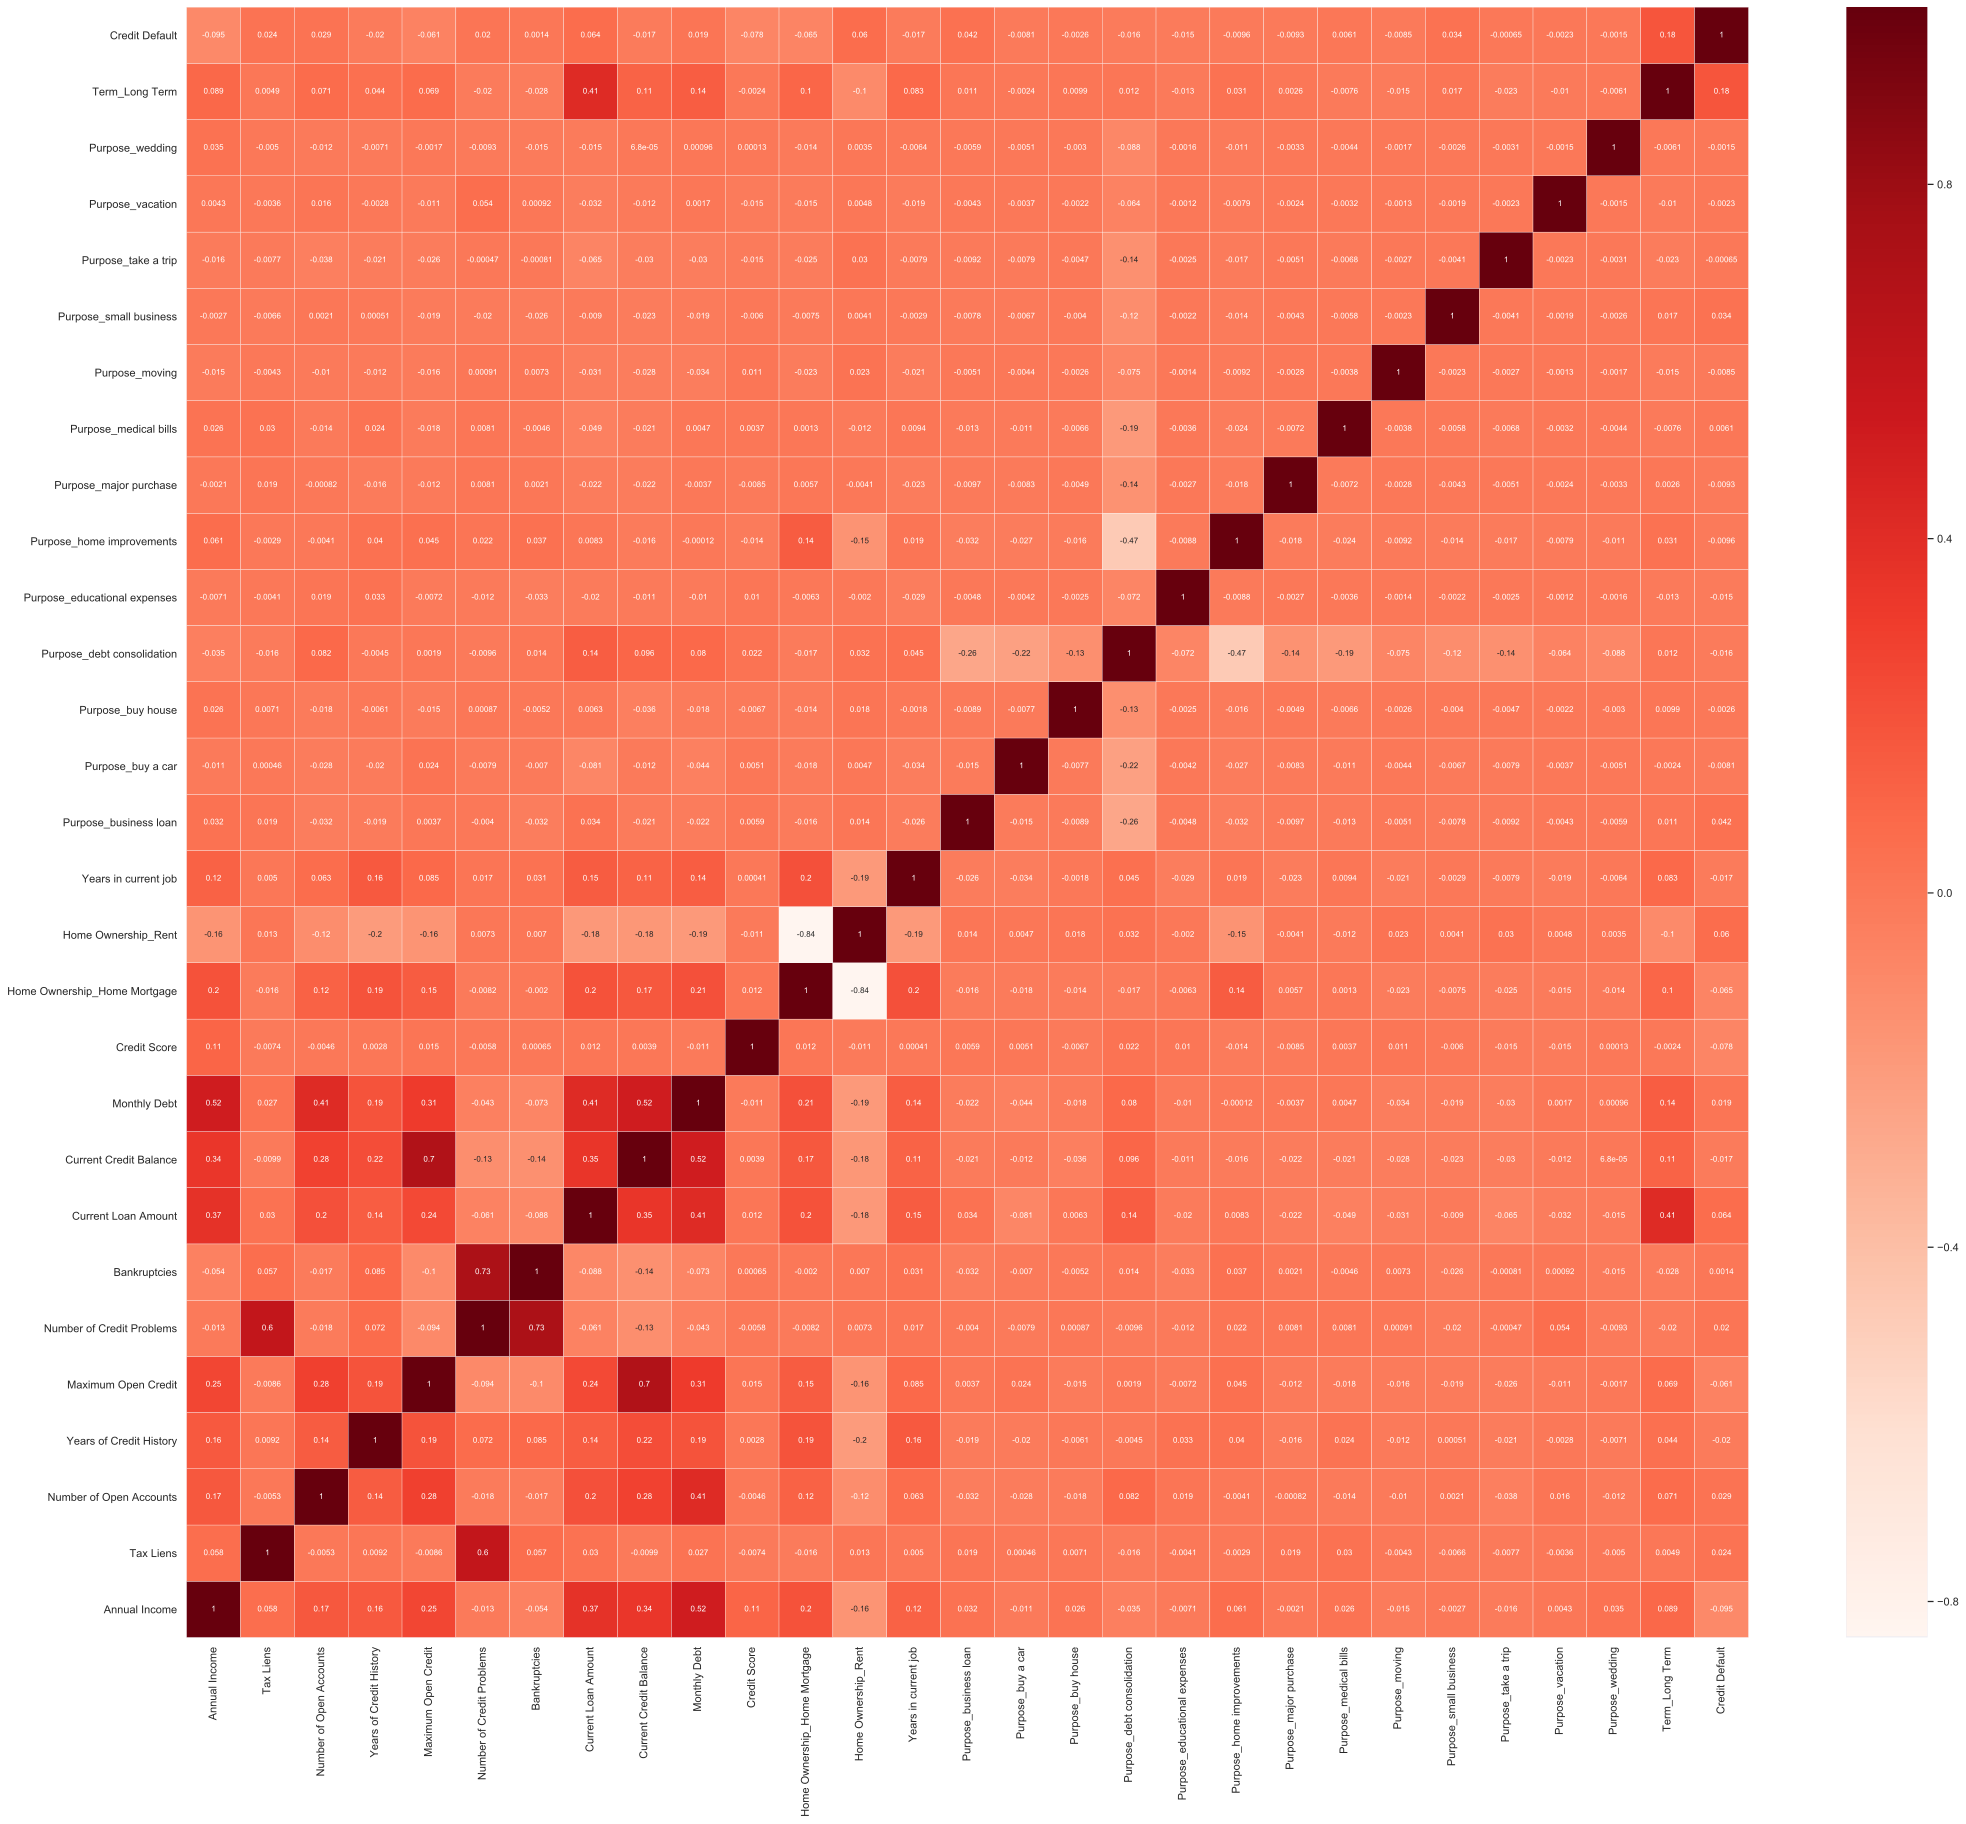

In [36]:
plt.figure(figsize=(35,30))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, annot_kws={"fontsize":8},linewidths=0.3)
plt.ylim([0,29])
plt.show()

**Split dataset on x,y**

In [37]:
y = train['Credit Default']
train.drop('Credit Default', axis=1, inplace=True)

**Standartization for RFE**

In [38]:
column_headers = list(train.columns)
data_scaler = StandardScaler()
train_for_rfe = train.copy()
train_for_rfe[column_headers] = data_scaler.fit_transform(train_for_rfe[column_headers])

In [39]:
train_for_rfe

Annual Income  Tax Liens  Number of Open Accounts  \
0             -1.11      -0.11                    -0.03   
1             -0.40      -0.11                     0.79   
2             -0.76      -0.11                    -0.03   
3             -0.69      -0.11                    -0.64   
4             -0.73      -0.11                     0.38   
...             ...        ...                      ...   
7495          -1.22      -0.11                    -1.66   
7496           0.28      -0.11                    -0.23   
7497           0.73      -0.11                     0.18   
7498          -0.21      -0.11                     2.01   
7499          -0.21      -0.11                    -0.64   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                        1.13                 0.02                       1.66   
1                       -0.43                 0.59                      -0.34   
2                        2.37                 0.59                      -0.34   
3                        0.59                -0.59                       1.66   
4                       -0.67                -0.32                       1.66   
...                       ...                  ...                        ...   
7495                    -1.39                -0.63                      -0.34   
7496                     1.16                 0.02                      -0.34   
7497                     1.96                 1.27                      -0.34   
7498                     1.16                 0.54                      -0.34   
7499                    -1.27                -0.21                      -0.34   

      Bankruptcies  Current Loan Amount  Current Credit Balance  Monthly Debt  \
0             2.53                 0.00                   -0.78         -0.87   
1            -0.33                -0.26                    0.35          0.01   
2            -0.33                 0.00                    0.07         -0.39   
3             2.53                -1.10                   -0.63         -0.58   
4            -0.33                -1.07                   -0.63         -0.93   
...            ...                  ...                     ...           ...   
7495         -0.33                -1.05                   -0.70         -1.38   
7496         -0.33                 0.79                    0.55         -0.46   
7497         -0.33                 0.00                    0.62         -0.49   
7498         -0.33                 1.79                    0.61          1.58   
7499         -0.33                -1.65                    0.00         -0.78   

      ...  Purpose_educational expenses  Purpose_home improvements  \
0     ...                         -0.04                      -0.24   
1     ...                         -0.04                      -0.24   
2     ...                         -0.04                      -0.24   
3     ...                         -0.04                      -0.24   
4     ...                         -0.04                      -0.24   
...   ...                           ...                        ...   
7495  ...                         -0.04                      -0.24   
7496  ...                         -0.04                      -0.24   
7497  ...                         -0.04                      -0.24   
7498  ...                         -0.04                      -0.24   
7499  ...                         -0.04                      -0.24   

      Purpose_major purchase  Purpose_medical bills  Purpose_moving  \
0                      -0.07                  -0.10           -0.04   
1                      -0.07                  -0.10           -0.04   
2                      -0.07                  -0.10           -0.04   
3                      -0.07                  -0.10           -0.04   
4                      -0.07                  -0.10           -0.04   
...                      ...                    ...             ...   
7495         

**checking features' importance by RFE**

In [40]:
#no of features
nof_list=np.arange(1,37)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(train_for_rfe, y, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 11
Score with 11 features: 0.729982


In [41]:
cols = list(train.columns)
model = LogisticRegression()
#Initializing RFE model
rfe = RFE(model,10)
#Transforming data using RFE
X_rfe = rfe.fit_transform(train,y)  
#Fitting the data to model
model.fit(X_rfe,y)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = list(temp[temp==True].index)
print(selected_features_rfe)

['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Current Loan Amount', 'Monthly Debt', 'Credit Score', 'Home Ownership_Home Mortgage', 'Years in current job', 'Purpose_debt consolidation', 'Term_Long Term']


**Choosing features**

In [42]:
#train = train[selected_features_rfe]

In [43]:
#choosen by feature_importance of XGB 
train=train[['Maximum Open Credit',
             'Annual Income',
             'Number of Open Accounts',
             'Years of Credit History',
             'Current Loan Amount',
             'Current Credit Balance',
             'Monthly Debt',
             'Credit Score',
             'Term_Long Term']]

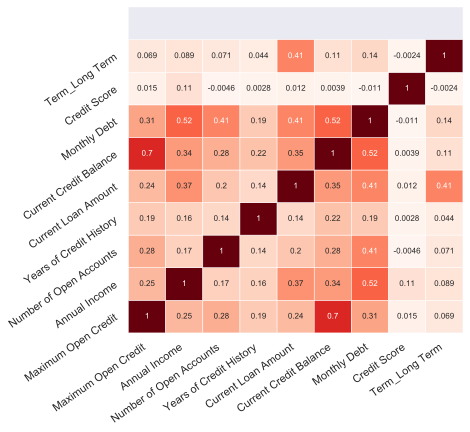

In [44]:
plt.figure(figsize=(6,6))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, annot_kws={"fontsize":8},linewidths=0.5, cbar=False)
plt.ylim([0,10])
plt.yticks(rotation=35, horizontalalignment='right')
plt.xticks(rotation=35, horizontalalignment='right')
plt.show()

**Standartization**

In [45]:
column_headers = list(train.columns)
data_scaler = StandardScaler()
train[column_headers] = data_scaler.fit_transform(train[column_headers])

**Division into test and train datasets**

In [46]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3, shuffle=True, random_state=30)

In [47]:
x_train

Maximum Open Credit  Annual Income  Number of Open Accounts  \
438                 -0.36          -1.26                    -0.84   
3383                -0.11          -0.21                     0.58   
7009                -0.34          -0.21                     0.18   
2963                 1.03           2.02                    -0.03   
3492                -0.33          -0.47                    -0.84   
...                   ...            ...                      ...   
501                  0.51          -0.46                     0.79   
3890                -0.31           0.90                    -0.43   
7092                 1.28          -0.14                     0.79   
4522                -0.22           0.58                    -0.03   
5931                 0.85           0.26                     2.42   

      Years of Credit History  Current Loan Amount  Current Credit Balance  \
438                     -0.06                -1.65                   -0.31   
3383                    -0.75                -1.19                   -0.76   
7009                    -0.63                -0.50                   -0.31   
2963                     1.01                -0.50                   -0.08   
3492                    -0.39                -0.25                   -0.26   
...                       ...                  ...                     ...   
501                      0.45                 0.50                    0.16   
3890                    -0.26                -0.23                    0.14   
7092                     2.07                 0.67                    1.32   
4522                     0.61                 1.71                    0.09   
5931                    -0.27                 0.12                    0.44   

      Monthly Debt  Credit Score  Term_Long Term  
438          -0.87          0.49           -0.59  
3383         -0.26         -1.95           -0.59  
7009          0.75         -1.95           -0.59  
2963         -0.05          0.61           -0.59  
3492         -1.00          0.57           -0.59  
...            ...           ...             ...  
501           0.17          0.45           -0.59  
3890          0.09          0.56           -0.59  
7092          0.03          0.60           -0.59  
4522          0.25          0.51            1.69  
5931          1.45          0.60           -0.59  

[5245 rows x 9 columns]

**Balancing the target variable**

In [48]:
y_train.value_counts()

0    3762
1    1483
Name: Credit Default, dtype: int64

In [49]:
#df_for_balancing = pd.concat([x_train, y_train], axis=1)
#df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
    
#df_balanced['Credit Default'].value_counts()

In [50]:
#x_train = df_balanced.drop(columns='Credit Default')
#y_train = df_balanced['Credit Default']

**Train model using**

**Logistic Regression**

In [51]:
logit = LogisticRegression(solver="saga")
logit.fit(x_train, y_train)
y_pred_train_logit = logit.predict(x_train)
y_pred_logit = logit.predict(x_test)

['Maximum Open Credit', 'Annual Income', 'Credit Score', 'Monthly Debt', 'Current Loan Amount', 'Current Credit Balance', 'Term_Long Term']


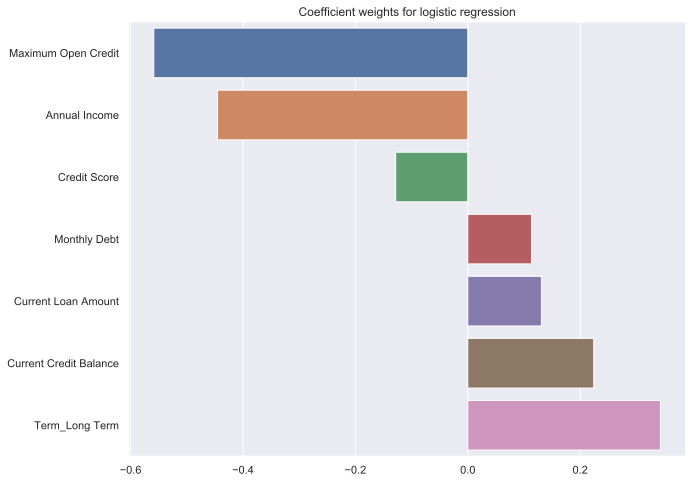

In [52]:
importance = logit.coef_
# summarize feature importance
most_import_log = []
vizual_log={}

for column,v in sorted(zip(train.columns, importance[0]), key = lambda x: x[1]):
    if (- 0.1 > v) or (0.1 < v):
        vizual_log[column] = v
        most_import_log.append(column)
print(most_import_log)
plt.figure(figsize=(10, 8))
sns.barplot(x=list(vizual_log.values()), y=list(vizual_log.keys()))

plt.title('Coefficient weights for logistic regression')
plt.show()

**Check prediction's quality**

In [53]:
print(classification_report(y_train, y_pred_train_logit))

              precision    recall  f1-score   support

           0       0.73      0.98      0.84      3762
           1       0.66      0.10      0.17      1483

    accuracy                           0.73      5245
   macro avg       0.70      0.54      0.51      5245
weighted avg       0.71      0.73      0.65      5245



In [54]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1618
           1       0.66      0.09      0.16       630

    accuracy                           0.73      2248
   macro avg       0.70      0.54      0.50      2248
weighted avg       0.71      0.73      0.65      2248



In [55]:
cnf_matrix = confusion_matrix(y_train, y_pred_train_logit)

For train dataset:

Confusion matrix, without normalization
[[3687   75]
 [1337  146]]


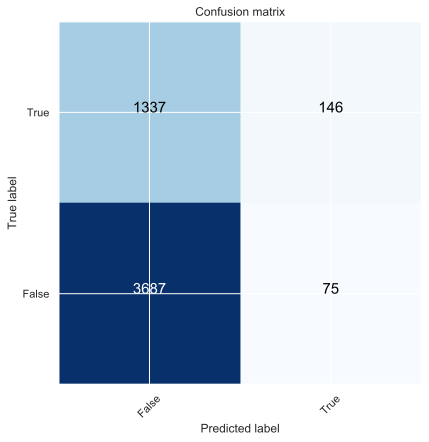

In [56]:
print(f'For train dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')

plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

In [57]:
cnf_matrix = confusion_matrix(y_test, y_pred_logit)

For test dataset:

Confusion matrix, without normalization
[[1587   31]
 [ 571   59]]


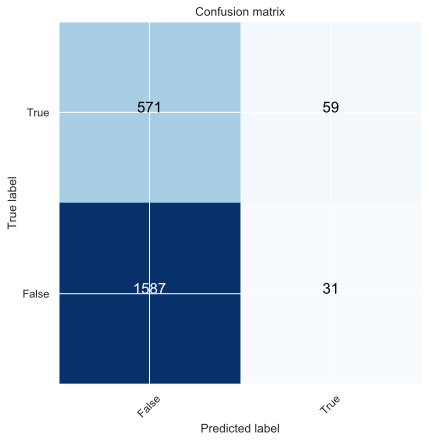

In [58]:
print(f'For test dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')
plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

**Support Vector Classifier**

In [59]:
clf = SVC(C=3, gamma="auto")

clf.fit(x_train, y_train)

y_pred_svc = clf.predict(x_test)
y_pred_train_svc = clf.predict(x_train)

In [60]:
print(classification_report(y_train, y_pred_train_svc))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      3762
           1       0.74      0.15      0.25      1483

    accuracy                           0.75      5245
   macro avg       0.74      0.57      0.55      5245
weighted avg       0.74      0.75      0.68      5245



In [61]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1618
           1       0.59      0.12      0.20       630

    accuracy                           0.73      2248
   macro avg       0.66      0.54      0.52      2248
weighted avg       0.70      0.73      0.66      2248



**KNN (K - near neighbors)**

In [62]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train, y_train)

y_pred_train_knn = knn.predict(x_train)
y_pred_test_knn = knn.predict(x_test)

**Check prediction's quality**

In [63]:
print(classification_report(y_train, y_pred_train_knn))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      3762
           1       0.59      0.24      0.34      1483

    accuracy                           0.74      5245
   macro avg       0.67      0.59      0.59      5245
weighted avg       0.71      0.74      0.70      5245



In [64]:
print(classification_report(y_test, y_pred_test_knn))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82      1618
           1       0.45      0.17      0.25       630

    accuracy                           0.71      2248
   macro avg       0.59      0.55      0.54      2248
weighted avg       0.66      0.71      0.66      2248



In [65]:
cnf_matrix = confusion_matrix(y_train, y_pred_train_knn)

For train dataset:

Confusion matrix, without normalization
[[3512  250]
 [1126  357]]


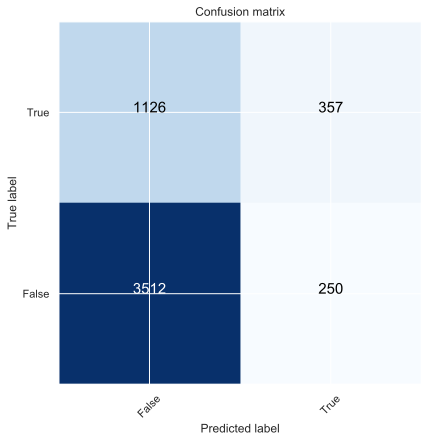

In [66]:
print(f'For train dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')

plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

In [67]:
cnf_matrix = confusion_matrix(y_test, y_pred_test_knn)

For train dataset:

Confusion matrix, without normalization
[[1483  135]
 [ 520  110]]


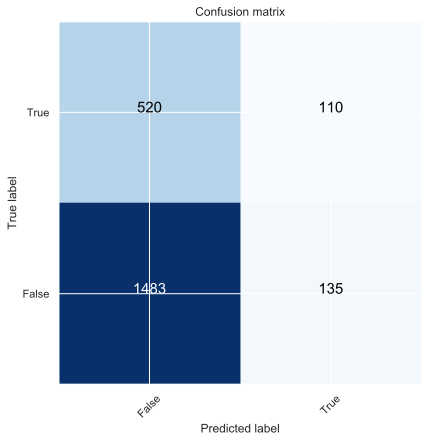

In [68]:
print(f'For train dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')

plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

**Random Forest**

In [69]:
model_rf = RandomForestClassifier(max_depth=8, max_features=5, n_estimators=700, class_weight={0:1,1:3.7})
model_rf.fit(x_train, y_train)

y_pred_train_rf = model_rf.predict(x_train)
y_pred_test_rf = model_rf.predict(x_test)

In [70]:
print(classification_report(y_train, y_pred_train_rf))

              precision    recall  f1-score   support

           0       0.97      0.68      0.80      3762
           1       0.53      0.95      0.68      1483

    accuracy                           0.75      5245
   macro avg       0.75      0.81      0.74      5245
weighted avg       0.85      0.75      0.76      5245



In [71]:
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.86      0.59      0.70      1618
           1       0.42      0.76      0.54       630

    accuracy                           0.64      2248
   macro avg       0.64      0.67      0.62      2248
weighted avg       0.74      0.64      0.65      2248



In [72]:
cnf_matrix = confusion_matrix(y_train, y_pred_train_rf)

For train dataset:

Confusion matrix, without normalization
[[2541 1221]
 [  81 1402]]


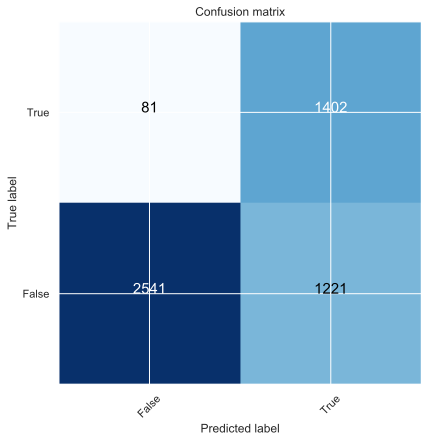

In [73]:
print(f'For train dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')

plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

In [74]:
cnf_matrix = confusion_matrix(y_test, y_pred_test_rf)

For test dataset:

Confusion matrix, without normalization
[[952 666]
 [152 478]]


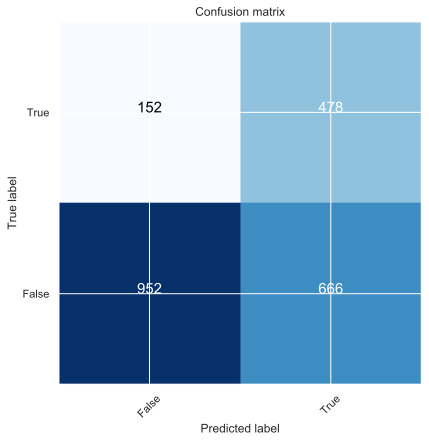

In [75]:
print(f'For test dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')

plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

**XGBoost**

In [76]:
model_xgb = xgb.XGBClassifier(max_depth=2,
              min_child_weight=6,
              n_estimators=300,
              learning_rate =0.11, random_state=87, scale_pos_weight = 2.54 )
model_xgb.fit(x_train, y_train)

y_pred_train_xgb = model_xgb.predict(x_train)
y_pred_test_xgb = model_xgb.predict(x_test)

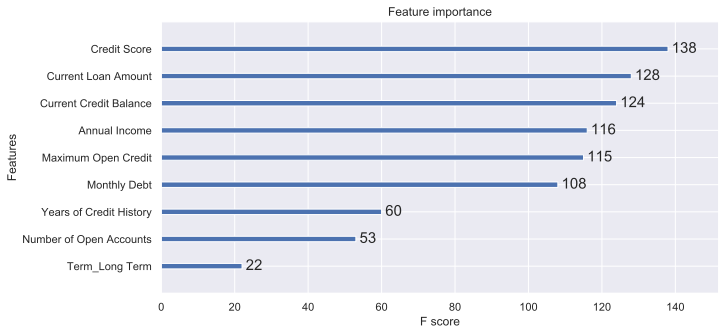

In [77]:
plot_importance(model_xgb)

In [78]:
print(classification_report(y_train, y_pred_train_xgb))

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      3762
           1       0.55      0.76      0.64      1483

    accuracy                           0.76      5245
   macro avg       0.72      0.76      0.73      5245
weighted avg       0.79      0.76      0.77      5245



In [79]:
print(classification_report(y_test, y_pred_test_xgb))

              precision    recall  f1-score   support

           0       0.85      0.69      0.77      1618
           1       0.47      0.69      0.56       630

    accuracy                           0.69      2248
   macro avg       0.66      0.69      0.66      2248
weighted avg       0.74      0.69      0.71      2248



In [80]:
cnf_matrix = confusion_matrix(y_train, y_pred_train_xgb)

For train dataset:

Confusion matrix, without normalization
[[2840  922]
 [ 352 1131]]


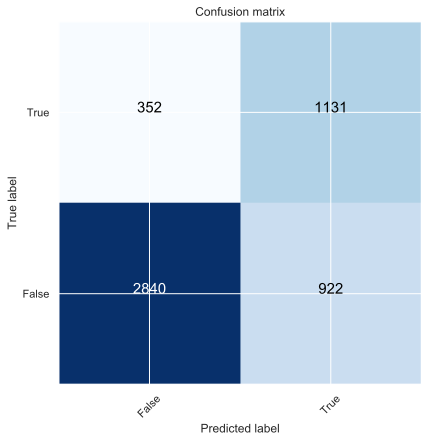

In [81]:
print(f'For train dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')

plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

In [82]:
cnf_matrix = confusion_matrix(y_test, y_pred_test_xgb)

For train dataset:

Confusion matrix, without normalization
[[1124  494]
 [ 195  435]]


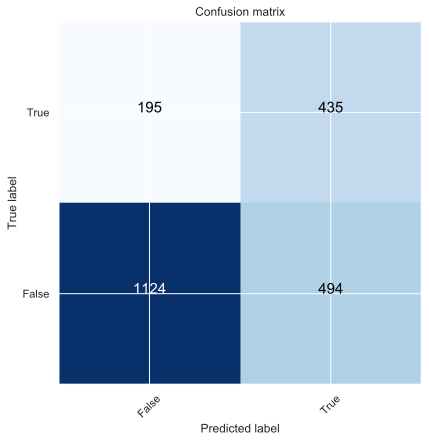

In [83]:
print(f'For train dataset:\n')
font = {'size' : 15}
plt.rc('font', **font)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      title='Confusion matrix')

plt.xlim([-0.5,1.5])
plt.ylim([-0.5,1.5])
plt.show()

**Check the best model's f1 score using cross-validation**

In [84]:
cv_score = cross_val_score(model_xgb, x_train, y_train, scoring="f1", cv=5)
# Then visualize the score you just obtain using mean, std or plot
print('Mean CV-score : ' + str(cv_score.mean()))

Mean CV-score : 0.5237281509570608


**Make adjustments for test dataset**

In [85]:
test.describe()

Annual Income  Tax Liens  Number of Open Accounts  \
count        1987.00    2500.00                  2500.00   
mean      1366921.68       0.04                    11.18   
std        917125.15       0.39                     4.85   
min        106533.00       0.00                     1.00   
25%        852311.50       0.00                     8.00   
50%       1178475.00       0.00                    10.00   
75%       1629734.50       0.00                    14.00   
max      14975610.00      15.00                    48.00   

       Years of Credit History  Maximum Open Credit  \
count                  2500.00              2500.00   
mean                     18.33            710570.41   
std                       7.25           1511983.48   
min                       3.90                 0.00   
25%                      13.40            278586.00   
50%                      17.00            478676.00   
75%                      22.10            802598.50   
max                      53.40          54484386.00   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                    2500.00                       1142.00       2497.00   
mean                        0.16                         34.18          0.11   
std                         0.56                         22.02          0.36   
min                         0.00                          0.00          0.00   
25%                         0.00                         16.00          0.00   
50%                         0.00                         30.00          0.00   
75%                         0.00                         50.00          0.00   
max                        15.00                         82.00          5.00   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count              2500.00                 2500.00       2500.00       1987.00  
mean           12155719.63               296396.65      18271.34       1234.52  
std            32260973.72               378301.97      11543.88       1740.22  
min               15422.00                    0.00         93.00        585.00  
25%              187126.50               110114.50      10024.75        710.00  
50%              322366.00               207385.00      16642.50        731.00  
75%              522582.50               366348.50      24146.00        743.00  
max            99999999.00              6030087.00      93555.00       7480.00

**Fixing outliers**

In [86]:
test.loc[test['Current Loan Amount'] > 1000000,'Current Loan Amount'] = test[test['Current Loan Amount'] < 1000000]['Current Loan Amount'].mean()

In [87]:
test.loc[test['Credit Score'] >1000,'Credit Score'] = test[test['Credit Score'] < 1000]['Credit Score'].mean()

**Fill in gaps (n/a values)**

In [88]:
test.loc[test['Annual Income'].isnull(),'Annual Income']=test['Annual Income'].median()
test.loc[test['Bankruptcies'].isnull(),'Bankruptcies']= -1
test.loc[test['Credit Score'].isnull(),'Credit Score']= -1
test.loc[test['Years in current job'].isnull(),'Years in current job'] = "-1"

In [89]:
test['Years in current job'] = test['Years in current job'].str.extract('(\d+)').astype(int)

In [90]:
#drop the "Months since last delinquent" column because there are too many empty values.
test.drop('Months since last delinquent', axis=1, inplace=True)

In [91]:
for obj_colname in test.select_dtypes(include='object').columns:
    print(str(obj_colname) + '\n\n' + str(test[obj_colname].value_counts()) + '\n' + '*' * 50 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
**************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64
**************************************************

Term

Short Term    1861
Long Term      639
Name: Term, dtype: int64
**************************************************



In [92]:
test.loc[test['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [93]:
for obj_colname in test.select_dtypes(include='object').columns:
    test = pd.concat([test, pd.get_dummies(test[obj_colname], prefix=obj_colname)], axis=1)

In [94]:
test = test[test.columns.drop(['Home Ownership', 'Years in current job', 'Purpose', 'Term'])]

**Choosing features**

In [95]:
test = test[column_headers]

**Standardization**

In [96]:
test[column_headers] = data_scaler.transform(test[column_headers])

**Final prediction**

In [97]:
# Getting answers
final_answers = model_xgb.predict(test)

In [98]:
answers = pd.DataFrame({'Id': test.index,
                       'Credit Default': final_answers})

In [99]:
answers

Id  Credit Default
0        0               1
1        1               1
2        2               1
3        3               0
4        4               0
...    ...             ...
2495  2495               0
2496  2496               1
2497  2497               1
2498  2498               0
2499  2499               1

[2500 rows x 2 columns]

In [100]:
#Saving to .csv
answers.loc[:, ['Id', 'Credit Default']].to_csv('Kirill_Volkov_solution.csv', float_format='%.2f', index = False)